<h1>Testing For Predictability With MASS and DREAMS Datasets - Full Bias</h1>

In [1]:
# Importing initial libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing libraries for machine learning via sk-learn:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


<h2>Loading The MASS and DREAMS QPS Parameter Dataset</h2>

In [2]:
dreams_path = r"C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\Active Projects\QPS Data Analysis\DREAMS Spindles (ONLY Spindles)\dreams_spindles_only.csv"
mass_path = r"C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\Active Projects\QPS Data Analysis\NLLS Comparison\biased.csv"

# Loading the DREAMS dataset into a dataframe:
df_dreams = pd.read_csv(dreams_path)

# Loading the MASS dataset into a dataframe:
df_mass = pd.read_csv(mass_path)

The DREAMS QPS (and other parameter) dataset will be used as the unseen dataset after training our machine learning model with the MASS dataset. An excerpt of all spindles extracted from the DREAMS EEG records is shown in the dataframe below.

In [3]:
df_dreams.head()

,a,b,c,d,e,f,spindle_duration_seconds,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,real_freq_hz,qrfr,label
0,1.598646,-0.568718,-1.771932,0.819241,80.081287,-10.084441,1.54,1189.604169,2724.831804,1535.227723,0.436579,0.563421,12.745333,12.337662,1.033043,1
1,2.441249,-3.194243,-21.685377,2.823842,84.916684,-5.539719,0.72,2240.489428,2305.975025,65.485598,0.971602,0.028398,13.514910,13.888889,0.973074,1
2,2.204273,4.181173,-20.060599,-2.351811,79.475552,8.598937,0.65,1725.426539,1742.021608,16.595069,0.990474,0.009526,12.648927,12.307692,1.027725,1
3,2.601240,-1.689561,-6.725640,1.323192,86.587116,-4.608373,0.50,3868.850850,4076.749514,207.898659,0.949004,0.050996,13.780768,14.000000,0.984341,1
4,2.495736,-1.101435,-9.472851,-1.821477,85.149284,4.888970,0.87,3163.736627,3444.052335,280.315713,0.918609,0.081391,13.551929,13.793103,0.982515,1


The MASS dataset is shown below. The dataset was produced with the intent of introducing bias between the spindles and non-spindles. That is, when a spindle was detected during the frame acquisition stage of the dataset creation process, the QPS parameters for the NLLS were initialised to their mean values known a posteriori while the QPS parameters were initialised to zero for non-spindles. This leads to a large separation in the classes that allows for accurate classification.

In [4]:
df_mass.head()

,a,b,c,d,e,f,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,0.527804,4.893096,-2.401058,2.483427e+06,-94.034062,8.893904,14.336918,2201.392070,2442.885499,239.349912,0.901144,0.097978,-14.965986,-1.043878,-2.367893,2.326263,0.978468,0.949751,0
1,-2.138058,-0.775656,-23.231398,2.536273e+07,-3.447090,25.445694,14.336918,0.155658,3340.112401,3340.266200,0.000047,1.000046,-0.548621,-0.038266,-9.065842,8.979945,3.655279,0.000530,0
2,-4.924472,3.994396,-19.380313,1.817975e+07,33.973295,-58.655407,15.360983,0.003054,916.628121,916.612111,0.000003,0.999983,5.407018,0.351997,-4.927009,5.082210,1.914797,0.007225,0
3,-0.665131,-5.405273,-18.372278,5.527986e+07,0.167347,0.000000,12.288786,0.199355,2977.612056,2977.808686,0.000067,1.000066,0.026634,0.002167,-7.961605,7.657919,3.451266,-0.023784,0
4,-0.912819,-0.146721,-0.072650,3.439822e+07,0.612192,0.000000,12.288786,1.167130,1864.917493,1866.686526,0.000626,1.000949,0.097433,0.007929,-7.064273,6.848352,2.732535,-0.005953,0


<h2>Separating Spindles and Non-Spindles For MASS</h2>

In [5]:
# Only pull out the QPS parameters for this case.
params = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
df_mass_s = df_mass[df_mass['label'] == 1][params].reset_index(drop=True)
df_mass_ns = df_mass[df_mass['label'] == 0][params]

# Shuffle the rows of the non-spindles:
df_mass_ns = df_mass_ns.sample(frac = 1).iloc[0:len(df_mass_s), :].reset_index(drop=True)

# Concatenate both dataframes:
df_mass_final = pd.concat([df_mass_s, df_mass_ns], axis=0).reset_index(drop=True)

<h2>Create and Train and SVM Model To Classify</h2>

In [6]:
# Shuffle the dataset:
df_mass_final = df_mass_final.sample(frac=1).reset_index(drop=True)

# Separate the labels from the training set:
X = df_mass_final[params[0:len(params)-1]]
y = df_mass_final['label']

# Split the dataset into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalise the training set and apply it to the test set:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate an empty SVM:
model = SVC(C=1.0, kernel='linear', gamma='auto')

# Perform k-fold CV using the model to verify that the accuracy is near 100%
acc_scores_cv = cross_val_score(model, X_train, y_train, cv=5)

print("List Of Accuracies For Each Fold = {}".format(acc_scores_cv))
print("Average Accuracy = {}%\n".format(round(np.mean(acc_scores_cv), 3) * 100))

# Once we've done that, evaluate the accuracy using the test set. Need to first fit the training set to the model.
model.fit(X_train, y_train)

# Predict the labels from X_test:
y_pred = model.predict(X_test)

# Evaluate the following metrics:
# - Accuracy
# - Precision (TP / TP + FP)
# - Recall (TP / TP + FN)
# - F1 Score (2*((precision*recall)/(precision+recall)))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print out the results:
print("Accuracy = {}%".format(round(np.mean(accuracy), 3) * 100))
print("Precision = {}%".format(round(np.mean(precision), 3) * 100))
print("Recall = {}%".format(round(np.mean(recall), 3) * 100))
print("F1 Score = {}%".format(round(np.mean(f1), 3) * 100))

List Of Accuracies For Each Fold = [0.99378882 0.99283325 0.98948375 0.99235182 0.98996176]
Average Accuracy = 99.2%

Accuracy = 99.4%
Precision = 98.8%
Recall = 99.9%
F1 Score = 99.4%


In [7]:
# Now, we use the DREAMS dataset to evaluate the quality of the model from 'unseen data'
df_dreams_qps = df_dreams[params]

# Separate into the features and the true labels:
X_dreams = df_dreams_qps[params[0:len(params)-1]]
y_dreams = df_dreams_qps['label']

# Normalise the X_dreams dataset:
X_dreams = scaler.transform(X_dreams)

# Fit the data to the model and get the predicted labels:
y_dreams_pred = model.predict(X_dreams)

# Assess the metrics of the model based off of using the DREAMS dataset:
accuracy_dreams = accuracy_score(y_dreams, y_dreams_pred)
precision_dreams = precision_score(y_dreams, y_dreams_pred)
recall_dreams = recall_score(y_dreams, y_dreams_pred)
f1_dreams = f1_score(y_dreams, y_dreams_pred)

# Print out the results:
print("Accuracy = {}%".format(round(np.mean(accuracy_dreams), 3)* 100))
print("Precision = {}%".format(round(np.mean(precision_dreams), 3)* 100))
print("Recall = {}%".format(round(np.mean(recall_dreams), 3)* 100))
print("F1 Score = {}%".format(round(np.mean(f1_dreams), 3)* 100))

Accuracy = 99.7%
Precision = 99.9%
Recall = 99.9%
F1 Score = 99.9%


<h2>Scatter plots for the MASS and DREAMS dataset</h2>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


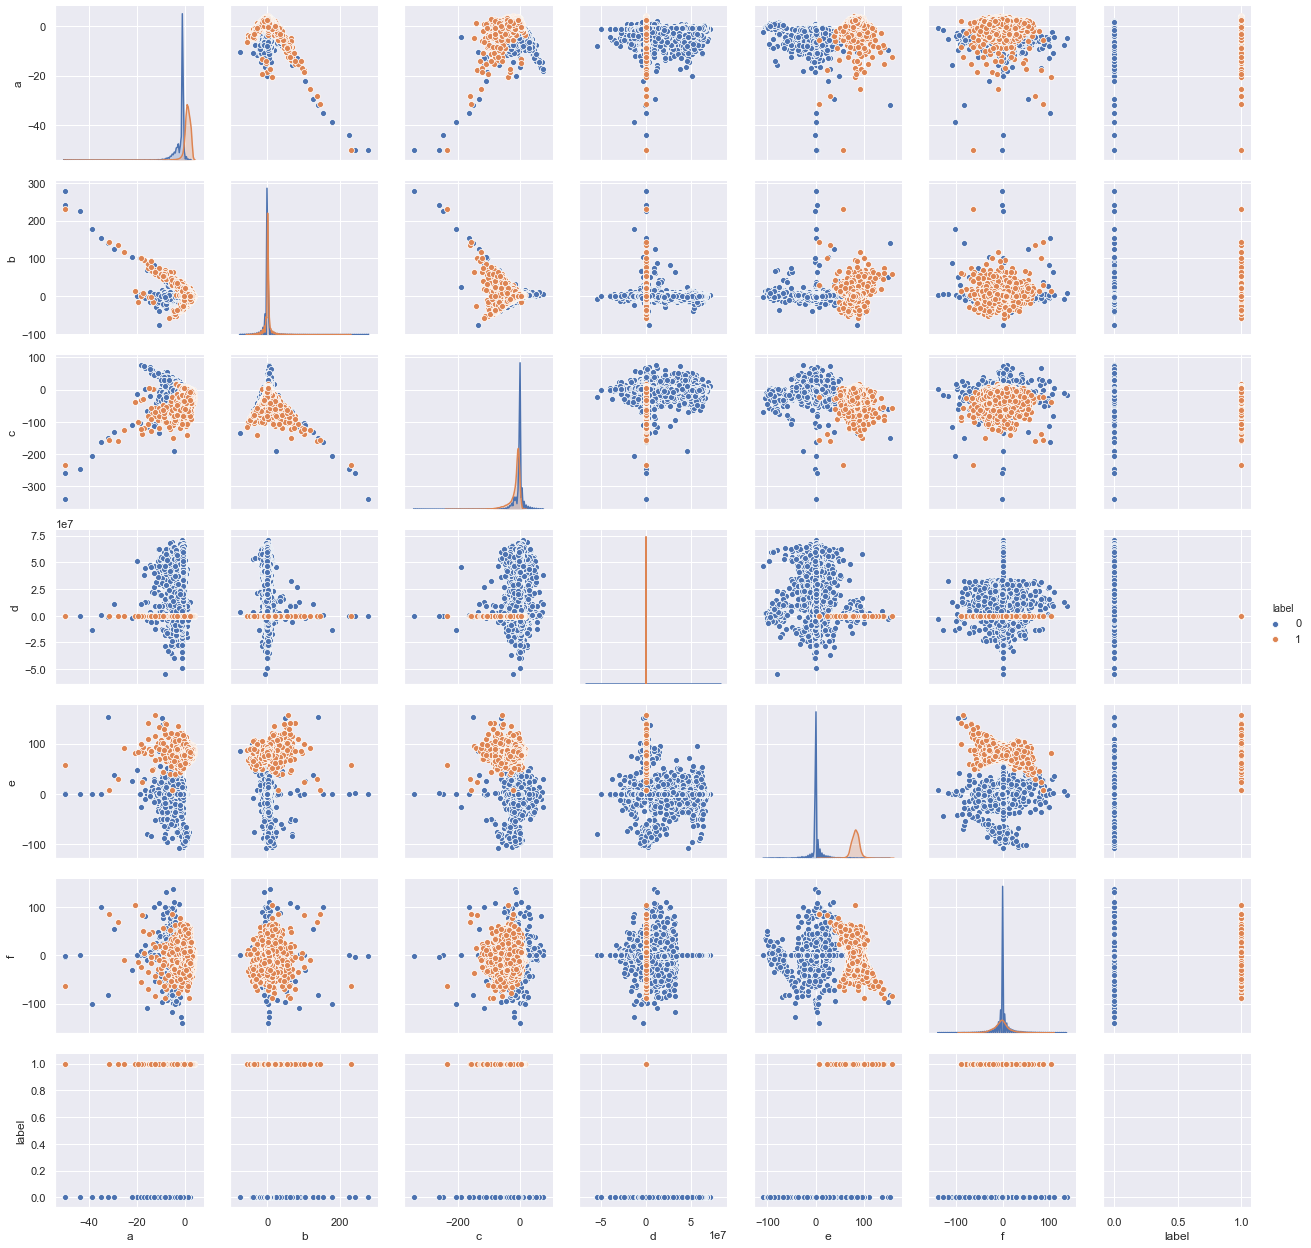

In [8]:
features = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
to_plot = df_mass_final[features].copy()
g = sns.pairplot(to_plot, hue='label')

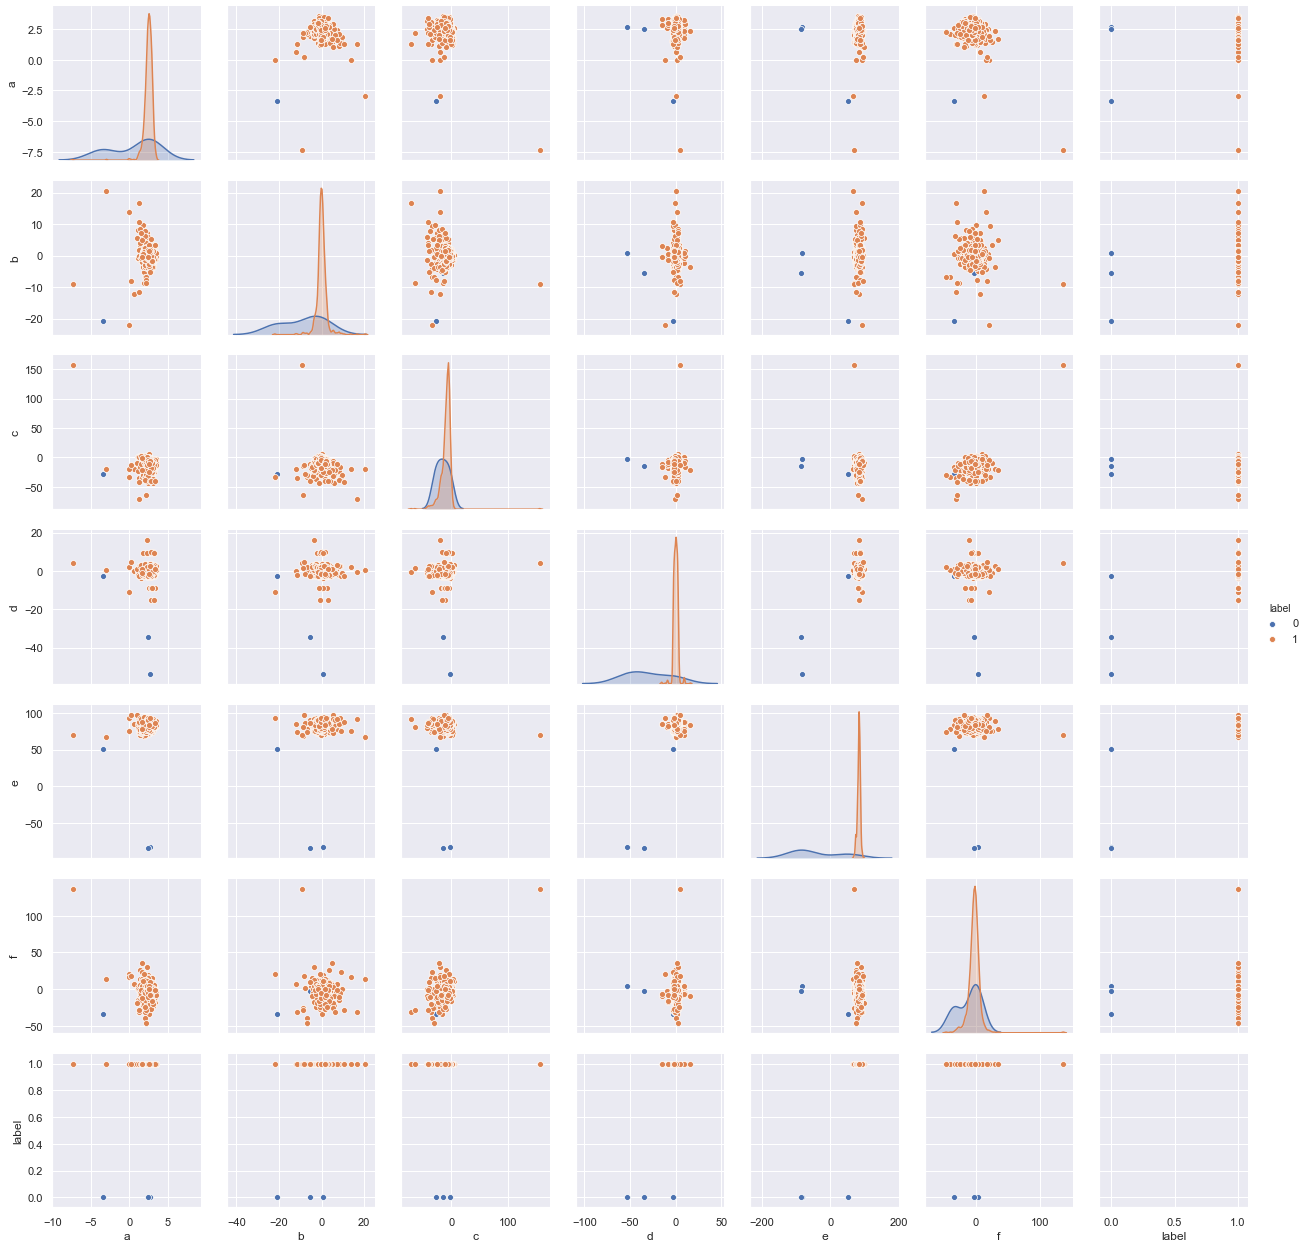

In [9]:
features = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
to_plot = df_dreams_qps[features].copy()
g = sns.pairplot(to_plot, hue='label')